In [1]:
import torch
import lightning
import matplotlib.pyplot as plt
from mlcolvar.utils.plot import plot_metrics

torch.manual_seed(42)

from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule
import pandas as pd

In [5]:
n_states = 2
file_names = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/COLVARS/COLVAR_top_1000_ca_sc",
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/unfolded/COLVARS/COLVAR_top_1000_ca_sc"]
dataset, df = create_dataset_from_files(file_names=file_names, return_dataframe=True)

Class 0 dataframe shape:  (120001, 1003)
Class 1 dataframe shape:  (50001, 1003)

 - Loaded dataframe (170002, 1003): ['time', 'd_CENTROID_30_HIS_CA_72_THR', 'd_CENTROID_30_HIS_CENTROID_72_THR', 'd_CENTROID_30_HIS_CA_73_GLY', 'd_CENTROID_13_GLN_CENTROID_63_ARG', 'd_CENTROID_30_HIS_CENTROID_73_GLY', 'd_CENTROID_6_TRP_CENTROID_55_LEU', 'd_CENTROID_23_ASP_CENTROID_68_ILE', 'd_CA_27_LEU_CENTROID_72_THR', 'd_CENTROID_30_HIS_CA_71_LEU', 'd_CENTROID_14_LEU_CENTROID_62_ARG', 'd_CENTROID_27_LEU_CENTROID_71_LEU', 'd_CENTROID_14_LEU_CA_63_ARG', 'd_CA_30_HIS_CENTROID_72_THR', 'd_CA_2_GLU_CA_46_GLN', 'd_CENTROID_6_TRP_CA_56_ASP', 'd_CENTROID_30_HIS_CENTROID_71_LEU', 'd_CA_13_GLN_CENTROID_63_ARG', 'd_CENTROID_14_LEU_CENTROID_59_LEU', 'd_CENTROID_27_LEU_CA_72_THR', 'd_CENTROID_26_ILE_CENTROID_72_THR', 'd_CENTROID_27_LEU_CENTROID_68_ILE', 'd_CENTROID_26_ILE_CENTROID_68_ILE', 'd_CENTROID_6_TRP_CENTROID_59_LEU', 'd_CENTROID_27_LEU_CENTROID_72_THR', 'd_CA_30_HIS_CA_72_THR', 'd_CENTROID_10_ALA_CENTROID_59

In [ ]:
X = dataset[:]['data']
labels = dataset[:]['labels']
print('X:',X.shape)
print('labels:',labels.shape)

X: torch.Size([170002, 1000])
labels: torch.Size([170002])


In [4]:
datamodule = DictModule(dataset,lengths=[0.8,0.2])  # training, validation, test
datamodule

DictModule(dataset -> DictDataset( "data": [170002, 1000], "labels": [170002] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))

### Deep-TDA for two states

In [5]:
from mlcolvar.cvs import DeepTDA

n_cvs = 1
target_centers = [60, 330]
target_sigmas = [10, 10]
nn_layers = [1000,60,30,1]

model = DeepTDA(n_states=n_states, n_cvs=n_cvs,target_centers=target_centers, target_sigmas=target_sigmas, layers=nn_layers)

In [6]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", mode='min', min_delta=1e-3, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=2000, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name    | Type          | Params | Mode  | In sizes | Out sizes
-------------------------------------------------------------------------
0 | loss_fn | TDALoss       | 0      | train | ?        | ?        
1 | norm_in | Normalization | 0      | train | [1000]   | [1000]   
2 | nn      | FeedForward   | 61.9 K | train | [1000] 

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1478: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, v_num=3]


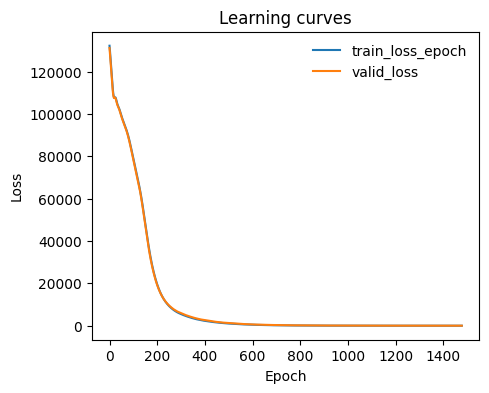

In [7]:
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  #yscale='log'
                  )

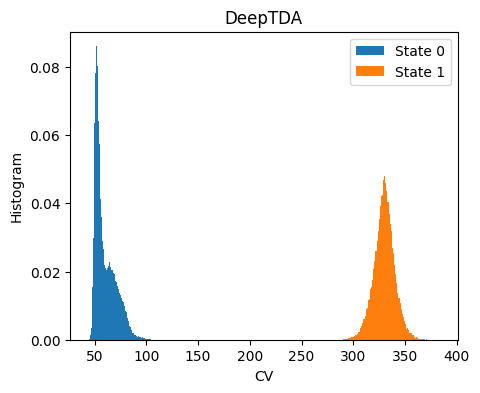

In [8]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

X = dataset[:]['data']
Y = dataset[:]['labels']

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i in range(n_states):
    s_red = s[torch.nonzero(Y==i, as_tuple=True)]
    ax.hist(s_red[:,0],bins=100, density=True, label=f'State {i}')

ax.set_xlabel(f'CV')
ax.set_ylabel('Histogram')
ax.set_title('DeepTDA')
plt.legend()
plt.show()

In [10]:
# Saving the model
x = torch.rand(1000, dtype=torch.float32, requires_grad=True).unsqueeze(0)
traced_cv = torch.jit.trace ( model, example_inputs=x)
filename='D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/Deep-TDA/top1000_ca_sc_deepTDA.pt'
traced_cv.save(filename)

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  if a.grad is not None:


### Lasso Regression

In [13]:
from sklearn import linear_model
from sklearn.linear_model import LassoCV
import numpy as np

with torch.no_grad(): # numpy to tensor to numpy
    XT = torch.Tensor(X)
    Smodel = model(XT)
    s = Smodel.numpy()
print(s.shape)
tda = s[:,0]
#tda = s
reg = LassoCV(cv=5, random_state=0, max_iter=100000).fit(X, tda)
print(reg.coef_)
print(reg.intercept_)
np.savetxt('D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/Deep-TDA/tda_coeff_top1000_ca_sc.txt',reg.coef_, )#fmt='%0.3f')

(170002, 1)
[ 19.12063437   0.           0.           5.11446915   0.
  15.91592296  13.08532871   0.           0.           4.47138017
   5.48710929   7.08841035   0.           0.           0.
   0.           0.           0.89180407   0.           2.87501133
   0.           0.           2.84319047   0.           0.
   8.16927079   4.34357763  -0.           0.           9.35406996
   3.36447681   0.           0.           2.72667603   0.
   0.           0.           9.2614988    0.           0.
   0.           3.51643156   3.19507133   0.           0.
   0.           0.           0.           6.8049378    0.
   0.           0.           0.           0.           6.05433344
   0.           0.           0.           0.           7.05416743
   0.           0.           0.           0.          -0.
   0.           0.           0.           0.          10.95940413
   5.71479726   0.          -0.           4.83498119  -0.
   0.           0.           0.           0.          -0.
   0.       

### Plotting by Trained Model

[[1.         0.99690901]
 [0.99690901 1.        ]]
0.9969090115400554
43.768624719460405 100.59997902906538
250.9675329844499 404.5368746199188


Text(0.5, 1.0, 'Deep-TDA CV vs LassoCV')

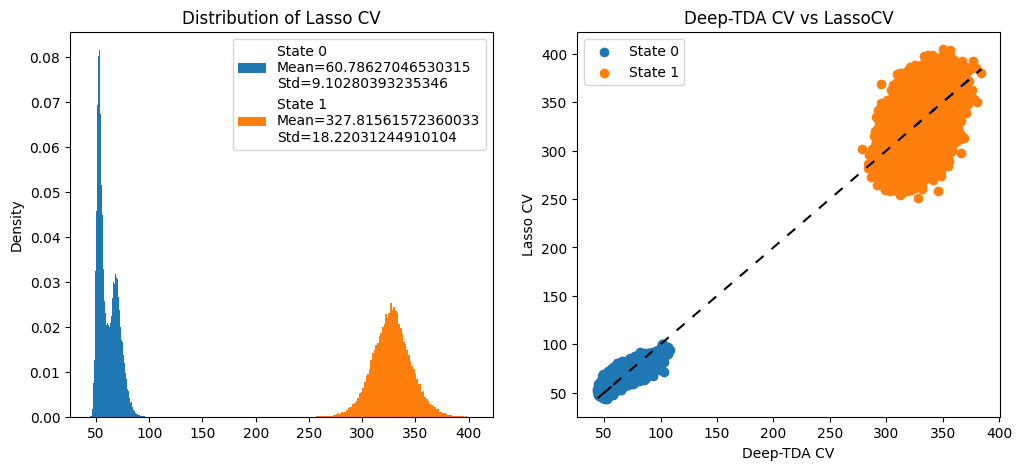

In [14]:
X_np = torch.Tensor(X).numpy()
ypred = reg.predict(X)
correlation_matrix = np.corrcoef(tda, ypred)
correlation_coefficient = correlation_matrix[0, 1]  # Extract the off-diagonal value
print(correlation_matrix)
print(correlation_coefficient)

labels_np = labels.numpy() if isinstance(labels, torch.Tensor) else np.array(labels)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i in range(n_states):
    ax[0].hist(ypred[labels_np == i], bins=100, density=True, label=f"State {i}\nMean={np.mean(ypred[labels_np == i])}\nStd={np.std(ypred[labels_np == i])}")
    print(np.min(ypred[labels_np == i]), np.max(ypred[labels_np == i]))
ax[0].set_ylabel("Density")
ax[0].set_title("Distribution of Lasso CV")
ax[0].legend()

for i in range(n_states):
    ax[1].scatter(tda[labels_np == i], ypred[labels_np == i], label=f"State {i}")
ax[1].legend()
ax[1].set_xlabel("Deep-TDA CV")
ax[1].set_ylabel("Lasso CV")
ax[1].plot(tda, tda, color='black', linestyle="--", dashes=(5,5))  # Plot diagonal y=x
ax[1].set_title("Deep-TDA CV vs LassoCV")

[[1.         0.87293298]
 [0.87293298 1.        ]]
[[1.         0.03913206]
 [0.03913206 1.        ]]


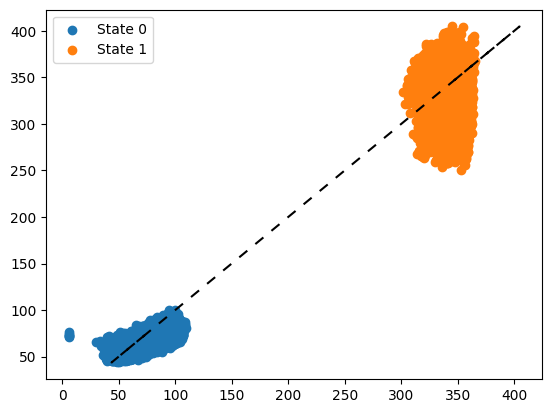

In [20]:
# Comparing against the original native rational CV
colvar_orig = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/COLVARS/COLVAR_native_rational",
               "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/unfolded/COLVARS/COLVAR_native_rational"]
native_folded = np.loadtxt(colvar_orig[0])[:,1]
native_unfolded = np.loadtxt(colvar_orig[1])[:,1]
correlation_matrix_0 = np.corrcoef(native_folded, ypred[labels_np == 0])
correlation_matrix_1 = np.corrcoef(native_unfolded, ypred[labels_np == 1])
print(correlation_matrix_0)
print(correlation_matrix_1)
#plt.hist(native_folded, bins=100, density=True, label="State 0")
#plt.hist(native_unfolded, bins=100, density=True, label="State 1")
plt.scatter(native_folded, ypred[labels_np == 0], label=f"State 0")
plt.scatter(native_unfolded, ypred[labels_np == 1], label=f"State 1")
plt.plot(ypred, ypred, color='black', linestyle="--", dashes=(5,5))
plt.legend()

### Plotting by Stored Coefficients

In [17]:
import numpy as np
import matplotlib.pyplot as plt
X_np = torch.Tensor(X).numpy()
#offset = -5.665675527871281
offset = 177.06186827610588
coefs = np.loadtxt("D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/Deep-TDA/tda_coeff_top1000_ca_sc.txt")
print(coefs)
lasso = np.dot(X_np, coefs) + offset
print(coefs.shape)
print(lasso.shape)
print(X)


[ 19.12063437   0.           0.           5.11446915   0.
  15.91592296  13.08532871   0.           0.           4.47138017
   5.48710929   7.08841035   0.           0.           0.
   0.           0.           0.89180407   0.           2.87501133
   0.           0.           2.84319047   0.           0.
   8.16927079   4.34357763  -0.           0.           9.35406996
   3.36447681   0.           0.           2.72667603   0.
   0.           0.           9.2614988    0.           0.
   0.           3.51643156   3.19507133   0.           0.
   0.           0.           0.           6.8049378    0.
   0.           0.           0.           0.           6.05433344
   0.           0.           0.           0.           7.05416743
   0.           0.           0.           0.          -0.
   0.           0.           0.           0.          10.95940413
   5.71479726   0.          -0.           4.83498119  -0.
   0.           0.           0.           0.          -0.
   0.           5.356465

43.76862471946038
404.53687461991905


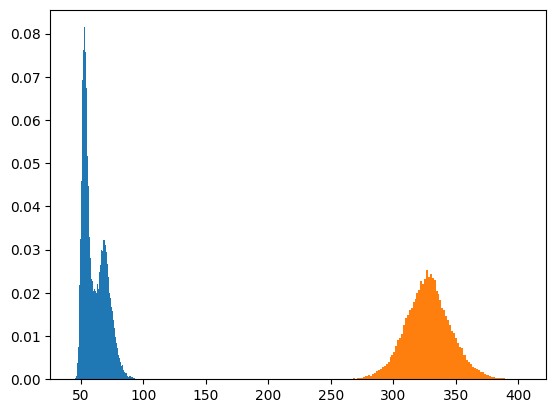

In [18]:
labels_np = labels.numpy() if isinstance(labels, torch.Tensor) else np.array(labels)
plt.hist(lasso[labels_np == 0], bins=100, density=True, label="Folded")
plt.hist(lasso[labels_np == 1], bins=100, density=True, label="Unfolded")
print(np.min(lasso[labels_np == 0]))
print(np.max(lasso[labels_np == 1]))

### Generating the PLUMED file

In [55]:
# I already have a plumed input file and only need to change the weights of each contact pair
#plumed_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/plumed_input_native_rational.dat"
plumed_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/plumed_input_native_rational.dat"
output_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/plumed_input_native_rational_lasso.dat"

updated_lines = []
counter = 1
weights = np.sqrt(reg.coef_)    # CMDIST squares the weights
with open(plumed_file, "r") as f:
    lines = f.readlines()
for line in lines:
    if line.startswith("ATOMS"):
        updated_line = line.replace(f"WEIGHT{counter}=1", f"WEIGHT{counter}={weights[counter-1]}")
        #updated_line = line.replace(f"WEIGHT1=1", f"WEIGHT1=4")
        updated_lines.append(updated_line)
        counter += 1
    elif line.startswith("..."):    # End of contact map
        if reg.intercept_ >= 0:
            updated_line = f"{line}\nlassoCV: MATHEVAL ARG=native FUNC=x+{abs(reg.intercept_)} PERIODIC=NO\n"
        elif reg.intercept_ < 0:
            updated_line = f"{line}\nlassoCV: MATHEVAL ARG=native FUNC=x-{abs(reg.intercept_)} PERIODIC=NO\n"
        updated_lines.append(updated_line)
    elif line.startswith("PRINT"):
        updated_line = "PRINT ARG=lassoCV STRIDE=1 FILE=COLVAR_native_rational_lasso"
        updated_lines.append(updated_line)
    else:
        updated_lines.append(line)
with open(output_file, "w") as f:
    f.writelines(updated_lines)
print(f"Successfully generated {output_file}")

Successfully generated D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/plumed_input_native_rational_lasso.dat


### Creating the PLUMED file from stored coefficients

In [23]:
plumed_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/plumed_input_native_rational.dat"
output_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/plumed_input_native_rational_lasso.dat"
coef_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/Deep-TDA/tda_coeff_native_rational.txt"
offset = -5.665675527871281

updated_lines = []
counter = 1
coefficients = np.loadtxt(coef_file).T
#weights = np.sqrt(coefficients)
with open(plumed_file, "r") as f:
    lines = f.readlines()
for line in lines:
    if line.startswith("ATOMS"):
        updated_line = line.replace(f"WEIGHT{counter}=1", f"WEIGHT{counter}={coefficients[counter-1]:0.6f}")
        updated_lines.append(updated_line)
        counter += 1
    elif line.startswith("..."):    # End of contact map
        if offset >= 0:
            updated_line = f"{line}\nlassoCV: MATHEVAL ARG=native FUNC=x+{abs(offset)} PERIODIC=NO\n"
        elif offset < 0:
            updated_line = f"{line}\nlassoCV: MATHEVAL ARG=native FUNC=x-{abs(offset)} PERIODIC=NO\n"
        updated_lines.append(updated_line)
    elif line.startswith("PRINT"):
        updated_line = "PRINT ARG=lassoCV STRIDE=1 FILE=COLVAR_native_rational_lasso"
        updated_lines.append(updated_line)
    else:
        updated_lines.append(line)
with open(output_file, "w") as f:
    f.writelines(updated_lines)
print(f"Successfully generated {output_file}")

Successfully generated D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/plumed_input_native_rational_lasso.dat


### Generating PLUMED file for distance discriptors from stored coeffs

In [40]:
feature_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/cmap_features_top1000_ca_sc_revised.txt"
feature_def_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/feature_definition_top1000_ca_sc.txt"
output_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/plumed_metad_top1000_lasso.dat"
coef_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/Deep-TDA/tda_coeff_top1000_ca_sc.txt"
offset = 177.06186827610588

updated_lines = []
counter = 1
coefficients = np.loadtxt(coef_file).T
with open(feature_file,"r") as f:
    features = f.readlines()

updated_lines.append("MOLINFO STRUCTURE=/home/ucbtzz3/Scratch/Enhanced_sampling/HemK/unfolded/em_protein.pdb MOLTYPE=protein\n\n"
                     "WHOLEMOLECULES ENTITY0=1-1168\n\n")

# Feature definition
with open(feature_def_file,"r") as f:
    lines = f.readlines()
for line in lines:
    updated_lines.append(line)
updated_lines.append("\n\nCONTACTMAP ...\n")

# Feature combination
for feature in features:
    updated_line = f"ATOMS{counter}={feature.split()[0]} SWITCH{counter}={{CUSTOM FUNC=x R_0=1 D_0=0.0}} WEIGHT{counter}={coefficients[counter-1]}\n"
    updated_lines.append(updated_line)
    counter += 1
updated_lines.append("LABEL=comb\n"
                     "SUM\n"
                     "NOPBC\n"
                     "... CONTACTMAP\n\n"
                     f"lassoCV: MATHEVAL ARG=comb FUNC=x+{offset} PERIODIC=NO\n\n")

# MetaD settings
updated_lines.append("METAD ...\n"
                     "ARG=lassoCV\n"
                     "PACE=250\n"
                     "HEIGHT=2\n"
                     "BIASFACTOR=100\n"
                     "SIGMA=4.5\n"
                     "GRID_MIN=0\n"
                     "GRID_MAX=450\n"
                     "INTERVAL=44,405\n"
                     "FILE=HILLS_comb\n"
                     "TEMP=298\n"
                     "CALC_RCT\n"
                     "LABEL=metad\n"
                     "... METAD\n\n"
                     "PRINT ARG=lassoCV,metad.rbias,metad.rct,metad.bias STRIDE=2500 FILE=COLVAR"
                     )

with open(output_file,'w') as f:
    f.writelines(updated_lines)

In [49]:
# using COMBINE for reference
feature_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/cmap_features_top1000_ca_sc_revised.txt"
feature_def_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/feature_definition_top1000_ca_sc.txt"
output_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/files_for_METAD_control/plumed_metad_top1000_lasso_comb.dat"
coef_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/Deep-TDA/tda_coeff_top1000_ca_sc.txt"
offset = 177.06186827610588

updated_lines = []
counter = 1
coefficients = np.loadtxt(coef_file).T
with open(feature_file,"r") as f:
    features = f.readlines()

updated_lines.append("MOLINFO STRUCTURE=/home/ucbtzz3/Scratch/Enhanced_sampling/HemK/unfolded/em_protein.pdb MOLTYPE=protein\n\n"
                     "WHOLEMOLECULES ENTITY0=1-1168\n\n")

# Feature definition
with open(feature_def_file,"r") as f:
    lines = f.readlines()
for line in lines:
    updated_lines.append(line)
updated_lines.append("\n\n")

# Feature combination
for feature in features:
    updated_line = f"d_{counter}: DISTANCE ATOMS{counter}={feature.split()[0]} NOPBC\n"
    updated_lines.append(updated_line)
    counter += 1

combine_line = "comb: COMBINE " + ",".join(f"d_{i+1}" for i in range(len(features))) + " COEFFICIENTS=" + ",".join(str(x) for x in coefficients) + " PERIODIC=NO"

updated_lines.append(f"{combine_line}\n\n"
                     f"lassoCV: MATHEVAL ARG=comb FUNC=x+{offset} PERIODIC=NO\n\n")

# MetaD settings
updated_lines.append("METAD ...\n"
                     "ARG=lassoCV\n"
                     "PACE=250\n"
                     "HEIGHT=2\n"
                     "BIASFACTOR=100\n"
                     "SIGMA=\n"
                     "GRID_MIN=0\n"
                     "GRID_MAX=420\n"
                     "FILE=HILLS_comb\n"
                     "TEMP=298\n"
                     "CALC_RCT\n"
                     "LABEL=metad\n"
                     "... METAD\n\n"
                     "PRINT ARG=lassoCV,metad.rbias,metad.rct,metad.bias STRIDE=2500 FILE=COLVAR"
                     )

with open(output_file,'w') as f:
    f.writelines(updated_lines)

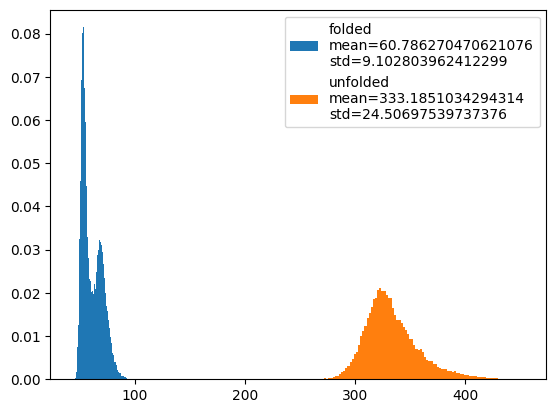

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Histogram from plumed driver
colvars = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/COLVARS/COLVAR_lasso_cmap",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/unfolded/COLVARS/COLVAR_top1000_lasso"]
time, folded_cv = np.genfromtxt(colvars[0], skip_header=1, unpack=True)
time, unfolded_cv = np.genfromtxt(colvars[1], skip_header=1, unpack=True)
folded_cv_std = np.std(folded_cv)
unfolded_cv_std = np.std(unfolded_cv)

print(folded_cv.max())
print(unfolded_cv.min())

plt.hist(folded_cv, bins=100, density=True, label=f"folded\nmean={np.mean(folded_cv)}\nstd={folded_cv_std}")
plt.hist(unfolded_cv, bins=100, density=True,label=f"unfolded\nmean={np.mean(unfolded_cv)}\nstd={unfolded_cv_std}")

plt.legend()

In [47]:
# Debugging

import re
def map_string(s):
    pattern = r'd_(CENTROID|CA)_(\d+)_\w+_(CENTROID|CA)_(\d+)_\w+'
    match = re.match(pattern, s)
    if not match:
        return None  # or raise an error
    
    type1, idx1, type2, idx2 = match.groups()
    
    def label(t, i):
        return 'sc_centroid_' + i if t == 'CENTROID' else 'c_alpha_' + i

    return f"{label(type1, idx1)},{label(type2, idx2)}"
# Comparing the order of features for debugging
with open("D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/COLVARS/COLVAR_top_1000_ca_sc", 'r') as f:
    line = f.readline()
pairs1 = line.split()[3:]
for i in range(len(pairs1)):
    pairs1[i] = map_string(pairs1[i])
with open("D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/COLVARS/COLVAR_top_1000_ca_sc", 'r') as f:
    line = f.readline()
pairs1_unfolded = line.split()[3:]
for i in range(len(pairs1_unfolded)):
    pairs1_unfolded[i] = map_string(pairs1_unfolded[i])

with open("D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/cmap_features_top1000_ca_sc.txt", 'r') as f:
    lines = f.readlines()
pairs2 = []
for line in lines:
    pairs2.append(line.split("=")[1].strip())

print(pairs1)
print(pairs1_unfolded)

# Write pairs1 to feature file
with open("D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/cmap_features_top1000_ca_sc_revised.txt", 'w') as f:
    f.writelines("\n".join(pairs1))

['sc_centroid_30,c_alpha_72', 'sc_centroid_30,sc_centroid_72', 'sc_centroid_30,c_alpha_73', 'sc_centroid_13,sc_centroid_63', 'sc_centroid_30,sc_centroid_73', 'sc_centroid_6,sc_centroid_55', 'sc_centroid_23,sc_centroid_68', 'c_alpha_27,sc_centroid_72', 'sc_centroid_30,c_alpha_71', 'sc_centroid_14,sc_centroid_62', 'sc_centroid_27,sc_centroid_71', 'sc_centroid_14,c_alpha_63', 'c_alpha_30,sc_centroid_72', 'c_alpha_2,c_alpha_46', 'sc_centroid_6,c_alpha_56', 'sc_centroid_30,sc_centroid_71', 'c_alpha_13,sc_centroid_63', 'sc_centroid_14,sc_centroid_59', 'sc_centroid_27,c_alpha_72', 'sc_centroid_26,sc_centroid_72', 'sc_centroid_27,sc_centroid_68', 'sc_centroid_26,sc_centroid_68', 'sc_centroid_6,sc_centroid_59', 'sc_centroid_27,sc_centroid_72', 'c_alpha_30,c_alpha_72', 'sc_centroid_10,sc_centroid_59', 'c_alpha_1,sc_centroid_47', 'sc_centroid_31,sc_centroid_72', 'c_alpha_23,sc_centroid_68', 'sc_centroid_2,c_alpha_44', 'sc_centroid_3,sc_centroid_28', 'c_alpha_10,sc_centroid_63', 'c_alpha_26,sc_cen

# Deep-TDA for the 605 native contact distances

In [50]:
n_states = 2
file_names = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/COLVARS/COLVAR_native_dists",
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/unfolded/COLVARS/COLVAR_native_dists"]
dataset, df = create_dataset_from_files(file_names=file_names, return_dataframe=True)

Class 0 dataframe shape:  (120001, 608)
Class 1 dataframe shape:  (50001, 608)

 - Loaded dataframe (170002, 608): ['time', 'd_5_103', 'd_19_86', 'd_7_100', 'd_7_103', 'd_7_715', 'd_7_729', 'd_7_737', 'd_7_740', 'd_10_103', 'd_10_737', 'd_10_742', 'd_13_737', 'd_13_742', 'd_14_100', 'd_14_103', 'd_14_737', 'd_14_742', 'd_14_747', 'd_14_765', 'd_14_778', 'd_20_100', 'd_20_737', 'd_20_741', 'd_22_700', 'd_22_715', 'd_22_729', 'd_22_741', 'd_33_741', 'd_34_90', 'd_34_98', 'd_24_700', 'd_24_703', 'd_24_715', 'd_27_703', 'd_27_715', 'd_30_703', 'd_30_715', 'd_31_729', 'd_31_737', 'd_31_741', 'd_32_705', 'd_32_713', 'd_35_693', 'd_35_700', 'd_35_715', 'd_35_729', 'd_37_700', 'd_37_754', 'd_37_756', 'd_37_760', 'd_55_114', 'd_55_118', 'd_55_121', 'd_55_123', 'd_55_458', 'd_55_756', 'd_39_121', 'd_39_123', 'd_39_644', 'd_39_632', 'd_39_696', 'd_39_700', 'd_39_729', 'd_43_729', 'd_43_741', 'd_43_760', 'd_52_644', 'd_52_630', 'd_52_632', 'd_52_693', 'd_52_696', 'd_45_526', 'd_45_718', 'd_45_720'

In [51]:
X = dataset[:]['data']
labels = dataset[:]['labels']
print('X:',X.shape)
print('labels:',labels.shape)

X: torch.Size([170002, 605])
labels: torch.Size([170002])


In [52]:
datamodule = DictModule(dataset,lengths=[0.8,0.2])  # training, validation, test
datamodule

DictModule(dataset -> DictDataset( "data": [170002, 605], "labels": [170002] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))

In [53]:
from mlcolvar.cvs import DeepTDA

n_cvs = 1
target_centers = [60, 330]
target_sigmas = [10, 5]
nn_layers = [605,60,30,1]

model = DeepTDA(n_states=n_states, n_cvs=n_cvs,target_centers=target_centers, target_sigmas=target_sigmas, layers=nn_layers)

In [54]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
early_stopping = EarlyStopping(monitor="valid_loss", mode='min', min_delta=1e-3, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics, early_stopping],
                     max_epochs=2000, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name    | Type          | Params | Mode  | In sizes | Out sizes
-------------------------------------------------------------------------
0 | loss_fn | TDALoss       | 0      | train | ?        | ?        
1 | norm_in | Normalization | 0      | train | [605]    | [605]    
2 | nn      | FeedForward   | 38.2 K | train | [605]  

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, v_num=4]


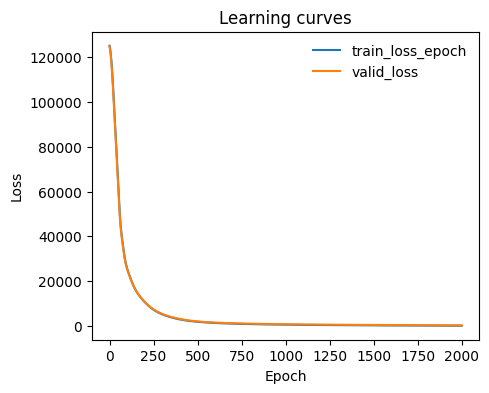

In [55]:
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss_epoch','valid_loss'],
                  #linestyles=['-.','-'], colors=['fessa1','fessa5'],
                  #yscale='log'
                  )

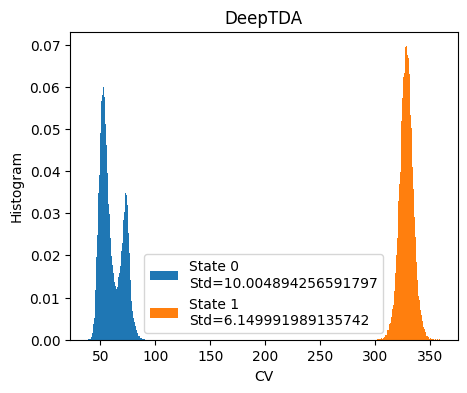

In [57]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

X = dataset[:]['data']
Y = dataset[:]['labels']

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i in range(n_states):
    s_red = s[torch.nonzero(Y==i, as_tuple=True)]
    ax.hist(s_red[:,0],bins=100, density=True, label=f'State {i}\nStd={np.std(s_red[:,0])}')

ax.set_xlabel(f'CV')
ax.set_ylabel('Histogram')
ax.set_title('DeepTDA')
plt.legend()
plt.show()

In [59]:
# Saving the model
x = torch.rand(605, dtype=torch.float32, requires_grad=True).unsqueeze(0)
traced_cv = torch.jit.trace ( model, example_inputs=x)
filename='D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/Deep-TDA/native_dist_deepTDA.pt'
traced_cv.save(filename)

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\jit\_trace.py:165: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  if a.grad is not None:


In [60]:
# Lasso regression
from sklearn import linear_model
from sklearn.linear_model import LassoCV
import numpy as np

with torch.no_grad(): # numpy to tensor to numpy
    XT = torch.Tensor(X)
    Smodel = model(XT)
    s = Smodel.numpy()
print(s.shape)
tda = s[:,0]
#tda = s
reg = LassoCV(cv=5, random_state=0, max_iter=100000).fit(X, tda)
print(reg.coef_)
print(reg.intercept_)
np.savetxt('D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/Deep-TDA/tda_coeff_native_dist.txt',reg.coef_, )#fmt='%0.3f')

(170002, 1)
[ 0.00000000e+00  0.00000000e+00  2.50266665e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  2.02695163e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -9.89285474e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.12529858e-02  2.04565537e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.32109177e+00  9.36921439e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.08764613e+01
  0.00000000e+00  6.64607173e+00  1.93812747e-02 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e

In [65]:
import numpy as np
import matplotlib.pyplot as plt
X_np = torch.Tensor(X).numpy()
#offset = -5.665675527871281
offset = -52.810606826166946
coefs = np.loadtxt("D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/Deep-TDA/tda_coeff_native_dist.txt")
print(coefs)
lasso = np.dot(X_np, coefs) + offset
print(coefs.shape)
print(lasso.shape)
print(X)

[ 0.00000000e+00  0.00000000e+00  2.50266665e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  2.02695163e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -9.89285474e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.12529858e-02  2.04565537e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.32109177e+00  9.36921439e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.08764613e+01
  0.00000000e+00  6.64607173e+00  1.93812747e-02 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000

45.44882253455887
392.50751170178785


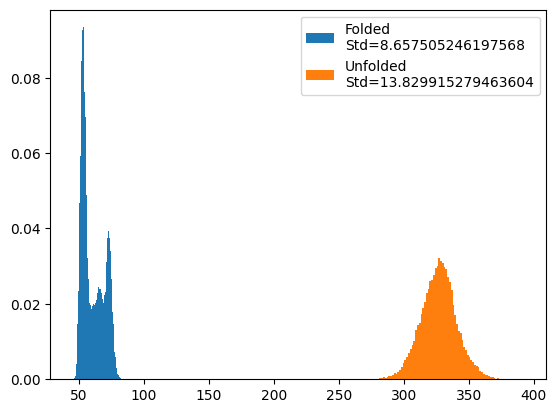

In [66]:
labels_np = labels.numpy() if isinstance(labels, torch.Tensor) else np.array(labels)
plt.hist(lasso[labels_np == 0], bins=100, density=True, label=f"Folded\nStd={np.std(lasso[labels_np == 0])}")
plt.hist(lasso[labels_np == 1], bins=100, density=True, label=f"Unfolded\nStd={np.std(lasso[labels_np == 1])}")
print(np.min(lasso[labels_np == 0]))
print(np.max(lasso[labels_np == 1]))
plt.legend()

In [ ]:
# Generate plumed file
feature_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/native_pairs_distances.dat"
output_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/files_for_METAD_control/plumed_metad_native_dist_lasso.dat"
coef_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/Deep-TDA/tda_coeff_native_dist.txt"
offset = -52.810606826166946

updated_lines = []
counter = 1
counter_lines = 1
coefficients = np.loadtxt(coef_file).T
with open(feature_file,"r") as f:
    features = f.readlines()

updated_lines.append("MOLINFO STRUCTURE=/home/ucbtzz3/Scratch/Enhanced_sampling/HemK/unfolded/em_protein.pdb MOLTYPE=protein\n\n"
                     "WHOLEMOLECULES ENTITY0=1-1168\n\n")

updated_lines.append("CONTACTMAP ...\n")

# Feature combination
for i in range(len(features)):
    if coefficients[i] != 0:    # Only use features with non-0 coefficient
        updated_line = f"ATOMS{counter}={features[i].split()[0]} SWITCH{counter}={{CUSTOM FUNC=x R_0=1 D_0=0.0}} WEIGHT{counter}={coefficients[i]}\n"
        updated_lines.append(updated_line)
        counter += 1

updated_lines.append("LABEL=comb\n"
                     "SUM\n"
                     "NOPBC\n"
                     "... CONTACTMAP\n\n"
                     f"lassoCV: MATHEVAL ARG=comb FUNC=x-{abs(offset)} PERIODIC=NO\n\n")

# MetaD settings
updated_lines.append("METAD ...\n"
                     "ARG=lassoCV\n"
                     "PACE=250\n"
                     "HEIGHT=2\n"
                     "BIASFACTOR=100\n"
                     "SIGMA=4.5\n"
                     "GRID_MIN=0\n"
                     "GRID_MAX=450\n"
                     "INTERVAL=44,405\n"
                     "FILE=HILLS_comb\n"
                     "TEMP=298\n"
                     "CALC_RCT\n"
                     "LABEL=metad\n"
                     "... METAD\n\n"
                     "PRINT ARG=lassoCV,metad.rbias,metad.rct,metad.bias STRIDE=2500 FILE=COLVAR"
                     )

with open(output_file,'w') as f:
    f.writelines(updated_lines)

93.670028
255.267269


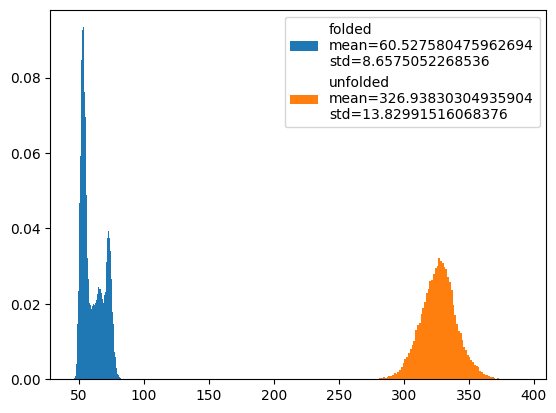

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# Histogram from plumed driver
colvars = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/COLVARS/COLVAR_native_dist_cmap",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/unfolded/COLVARS/COLVAR_native_dist_cmap"]
time, folded_cv = np.genfromtxt(colvars[0], skip_header=1, unpack=True)
time, unfolded_cv = np.genfromtxt(colvars[1], skip_header=1, unpack=True)
folded_cv_std = np.std(folded_cv)
unfolded_cv_std = np.std(unfolded_cv)

print(folded_cv.max())
print(unfolded_cv.min())

plt.hist(folded_cv, bins=100, density=True, label=f"folded\nmean={np.mean(folded_cv)}\nstd={folded_cv_std}")
plt.hist(unfolded_cv, bins=100, density=True,label=f"unfolded\nmean={np.mean(unfolded_cv)}\nstd={unfolded_cv_std}")

plt.legend()